In [1]:
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pysindy as ps

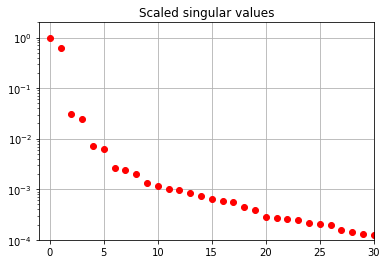

In [2]:
# Load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.loadtxt("data/plasmaphysics_example_trajectories.txt")
t = A[:, 0]
A = A[:,1:]

# Load in the corresponding SVD data and plot it
S = np.loadtxt("data/plasmaphysics_example_singularValues.txt")
fig, ax = plt.subplots(1, 1)
ax.semilogy(S / S[0], "ro")
ax.set(title="Scaled singular values", xlim=[-1, 30], ylim=[1e-4, 2])
ax.grid()

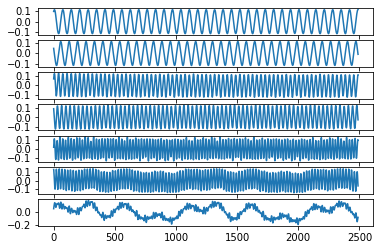

In [3]:
r = 7
poly_order = 2
threshold = 0.05
tfrac = 0.8  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]

# Normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1:r + 1])
x = np.zeros((A.shape[0], r))
plt.figure()
for i in range(r):
    x[:, i] = A[:, i] / normalization
    plt.subplot(r, 1, i + 1)
    plt.plot(x[:, i])

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

In [14]:
# We need a quadratic library with particular ordering 
# for the model constraints that we use later
library_functions = [lambda x:x]
library_function_names = [lambda x:x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

# Working with Shaowu Koopman stability paper Eq 2.31
# need r(r-1) / 2 equality constraints for the antisymmetry
# and r(r-1) / 2 equality constraints for setting most of the off-diagonals to zero
# and r inequality constraints for the diagonal

num_constraints = int(r * (r + 1) / 2 + (r - 1) * (r - 2) / 2)
num_coefficients = int(r ** 2)
constraint_zeros = np.zeros(num_constraints)
constraint_matrix = np.zeros((num_constraints, num_coefficients))

# Define the constraint matrix
q = r
for i in range(r):
    # Constraint that the diagonal must be negative real numbers since asking that these satisfy < 0
    constraint_matrix[i, i * (r + 1)] = 1.0
    counter = 1
    # Constraint of anti-symmetry
    for j in range(i + 1, r):
        constraint_matrix[q, i * r + j] = 1.0
        constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
        counter += 1
        q += 1

# Constraint of zero off-diagonal terms except nearest off-diagonal (see Eq 2.31)
q = r
for i in range(r):
    counter = 1
    for j in range(i + 2, r):
        constraint_matrix[q + int(r * (r - 1) / 2), i * r + j] = 1.0
        counter += 1
        q += 1
        
print(constraint_matrix[-1, :])

threshold = 0.0
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    thresholder='l1',
    nu=1e-5,
    max_iter=10000,
    tol=1e-6,
    equality_constraints=True,
    inequality_constraints=True,
    constraint_separation_index=r,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [15]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)

model.fit(x_train, t=t_train)
model.print()

(x0)' = 0.091 x1
(x1)' = -0.091 x0
(x2)' = 0.179 x3
(x3)' = -0.179 x2 + -0.001 x3
(x4)' = 0.263 x5
(x5)' = -0.263 x4 + 0.003 x6
(x6)' = -0.003 x5


In [16]:
Xi = model.coefficients()
model.get_feature_names()

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

In [17]:
print(Xi, Xi.shape, np.sort(np.real(np.linalg.eigvals(Xi))))
print(sindy_opt.coef_full_, np.sort(np.real(np.linalg.eigvals(sindy_opt.coef_full_))))

[[ 5.69998010e-07  9.06430921e-02  6.18586498e-12 -4.33631098e-12
  -3.41772849e-12 -1.58221788e-12 -1.25799828e-11]
 [-9.06430921e-02 -3.87710562e-05 -2.27201428e-04 -4.02986035e-14
  -9.66811466e-12 -2.38241101e-14 -6.48768423e-12]
 [-1.50663272e-11  2.27201432e-04  1.88175857e-06  1.78784289e-01
  -2.12368849e-12 -6.55043553e-12  5.12873646e-12]
 [ 4.37986915e-12  8.45566158e-14 -1.78784289e-01 -5.20269490e-04
  -1.97163406e-04 -8.13969278e-15 -5.17879804e-12]
 [ 9.13985135e-12  1.93025972e-11 -4.23333823e-12  1.97163414e-04
   1.41341381e-06  2.62760876e-01  2.42686903e-13]
 [ 1.64528781e-12  3.81375937e-14  6.59098705e-12  1.63339060e-14
  -2.62760876e-01 -3.35134110e-04  2.96465534e-03]
 [ 3.52862829e-11  1.29754962e-11  5.96702152e-12  1.03526010e-11
   2.48402147e-12 -2.96465534e-03  1.29716640e-06]] (7, 7) [-2.59192982e-04 -2.59192982e-04 -1.66860536e-04 -1.66860536e-04
 -1.91012330e-05 -1.91012330e-05  1.29718123e-06]
[[ 1.04851521e-04  9.04202578e-02  1.07716718e-04 -1.10324

In [22]:
Xi[abs(Xi)<1e-5] = 0.0
print(Xi, np.real(np.linalg.eigvals(Xi)))

[[ 0.00000000e+00  9.06430921e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.06430921e-02 -3.87710562e-05 -2.27201428e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.27201432e-04  0.00000000e+00  1.78784289e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.78784289e-01 -5.20269490e-04
  -1.97163406e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.97163414e-04
   0.00000000e+00  2.62760876e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.62760876e-01 -3.35134110e-04  2.96465534e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.96465534e-03  0.00000000e+00]] [-1.93862325e-05 -1.93862325e-05 -2.60133860e-04 -2.60133860e-04
 -1.67567236e-04 -1.67567236e-04  1.50570804e-29]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

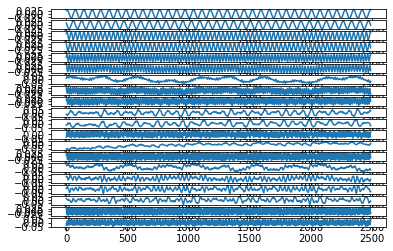

In [27]:
# Okay let's make sure it works at high numbers of modes:
r = 20
poly_order = 2
threshold = 0.05
tfrac = 0.5  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]

# Normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1:r + 1])
x = np.zeros((A.shape[0], r))
plt.figure()
for i in range(r):
    x[:, i] = A[:, i] / normalization
    plt.subplot(r, 1, i + 1)
    plt.plot(x[:, i])

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

num_constraints = int(r * (r + 1) / 2 + (r - 1) * (r - 2) / 2)
num_coefficients = int(r ** 2)
constraint_zeros = np.zeros(num_constraints)
constraint_matrix = np.zeros((num_constraints, num_coefficients))

# Define the constraint matrix
q = r
for i in range(r):
    # Constraint that the diagonal must be negative real numbers since asking that these satisfy < 0
    constraint_matrix[i, i * (r + 1)] = 1.0
    counter = 1
    # Constraint of anti-symmetry
    for j in range(i + 1, r):
        constraint_matrix[q, i * r + j] = 1.0
        constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
        counter += 1
        q += 1

# Constraint of zero off-diagonal terms except nearest off-diagonal (see Eq 2.31)
q = r
for i in range(r):
    counter = 1
    for j in range(i + 2, r):
        constraint_matrix[q + int(r * (r - 1) / 2), i * r + j] = 1.0
        counter += 1
        q += 1
        
print(constraint_matrix[-1, :])

threshold = 0.0
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    thresholder='l1',
    nu=1e-5,
    max_iter=10000,
    tol=1e-6,
    equality_constraints=True,
    inequality_constraints=True,
    constraint_separation_index=r,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
)

In [28]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)

model.fit(x_train, t=t_train)
model.print()

(x0)' = 0.091 x1
(x1)' = -0.091 x0
(x2)' = 0.179 x3
(x3)' = -0.179 x2 + -0.001 x3
(x4)' = 0.264 x5
(x5)' = -0.264 x4 + 0.003 x6
(x6)' = -0.003 x5 + -0.006 x7
(x7)' = 0.006 x6 + -0.002 x7 + -0.336 x8
(x8)' = 0.336 x7 + 0.033 x9
(x9)' = -0.033 x8 + -0.001 x9 + 0.082 x10
(x10)' = -0.082 x9 + -0.005 x11
(x11)' = 0.005 x10 + -0.001 x11 + 0.001 x12
(x12)' = -0.001 x11 + -0.002 x12 + 0.011 x13
(x13)' = -0.011 x12 + 0.073 x14
(x14)' = -0.073 x13 + 0.016 x15
(x15)' = -0.016 x14 + -0.003 x15 + -0.143 x16
(x16)' = 0.143 x15 + -0.016 x17
(x17)' = 0.016 x16 + -0.061 x18
(x18)' = 0.061 x17 + -0.001 x18 + 0.492 x19
(x19)' = -0.492 x18


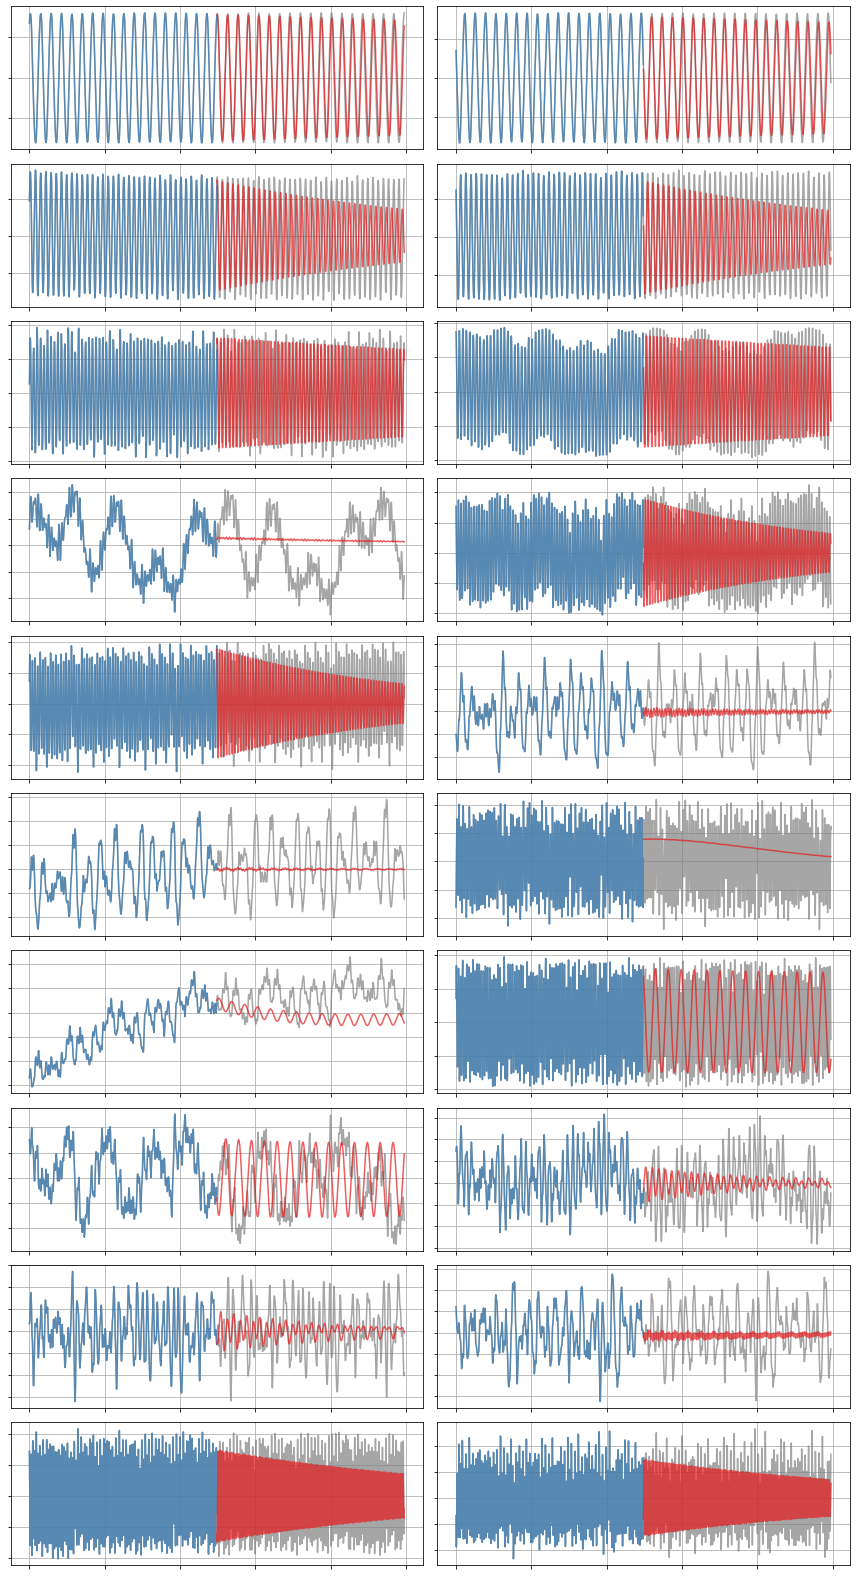

In [29]:
cmap = plt.get_cmap("Set1")

def plot_trajectories(x, x_train, x_sim, n_modes=None):
    """
    Compare x (the true data), x_train (predictions on the training data),
    and x_sim (predictions on the test data).
    """
    if n_modes is None:
        n_modes = x_sim.shape[1]

    n_rows = (n_modes + 1) // 2
    kws = dict(alpha=0.7)

    fig, axs = plt.subplots(n_rows, 2, 
                            figsize=(12, 2 * (n_rows + 1)), 
                            sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(t, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1), 
                label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0), 
                label="Predicted (test)", **kws)

    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[], yticklabels=[])

    fig.tight_layout()

# Forecast the testing data with this identified model
x_sim = model.simulate(x0_test, t_test)

# Compare true and simulated trajectories
plot_trajectories(x, x_train, x_sim, n_modes=r)

### Doesn't look like high performance but it is stable!!!